# Reviews Topic Modeling

In [296]:
# !pip install -q --disable-pip-version-check -r ../requirements.txt

In [297]:
# Randomization for seed reproduction
import random

# Matrix operations
import numpy as np

# Dataframes
import pandas as pd

# Regular Expressions
import re

# Import unidecode (to remove accents from words)
from unidecode import unidecode

# Import wordcloud
from wordcloud import WordCloud

# Sklearn Utilities
from sklearn.cluster import KMeans
from sklearn.decomposition import LatentDirichletAllocation

# Visualize the information contained in a topic model
import pyLDAvis
from pyLDAvis import gensim as gensimvis

import gensim
from gensim import corpora

# Charts
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px

# SciKit Learn Utilities
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
# from sklearn.preprocessing import OneHotEncoder
# from sklearn.manifold import TSNE
# from sklearn.utils import shuffle
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import confusion_matrix

# Natural Language Toolkit
import nltk
from nltk.tokenize import word_tokenize

# Language Detection
from langdetect import detect


In [298]:
# Set a random seed for reproducibility
random_seed = 10
np.random.seed(random_seed)
random.seed(random_seed)

---
## 1. Displaying initial data

In [299]:
reviews_df = pd.read_csv('../data/Big_AHR.csv', index_col=0)
reviews_df.head()

title  rating  \
0  Excelente y personal amable       5   
1                     Céntrico       4   
2            Hotel excepcional       5   
3                        WOW!!       5   
4                    Magnifico       5   

                                         review_text  \
0  Un hotel muy bueno.  El personal fue muy amabl...   
1  Muy buen hotel al nivel de lo esperado, habita...   
2  Magnífico hotel. La verdad es que todo perfect...   
3  Hotel hermoso, buen diseño, original, limpio. ...   
4  Magnífica ubicación en pleno centro de Sevilla...   

                                location                 hotel  label  
0  Seville_Province_of_Seville_Andalucia  H10_Casa_de_la_Plata      1  
1  Seville_Province_of_Seville_Andalucia  H10_Casa_de_la_Plata      1  
2  Seville_Province_of_Seville_Andalucia  H10_Casa_de_la_Plata      1  
3  Seville_Province_of_Seville_Andalucia  H10_Casa_de_la_Plata      1  
4  Seville_Province_of_Seville_Andalucia  H10_Casa_de_la_Plata      1

Obtain an example from the dataset:

In [300]:
def get_one_sample_with_columns(df, id=0):
    return list(zip(list(df.columns), list(df.iloc[id])))

Display the rating and the sentiment associated to the review:

In [301]:
def display_ratings(df):
    rating = df['rating'].value_counts()

    fig = px.bar(
        x=rating.index,
        y=rating.values,
        labels={'x': 'Rating', 'y': 'Count'},
        title='Count of Each Unique Rating'
    )

    fig.show()

In [302]:
def display_review_sentiment(df):
    SENTIMENT_CONVERSION = { 0: "Negative", 1: "Positive", 3: "Neutral" }

    sentiment_column = df['label'].value_counts().sort_index()

    fig = px.bar(
        # Convert numerical x-axis labels to string labels
        x=[SENTIMENT_CONVERSION[label] for label in sentiment_column.index],
        y=sentiment_column.values,
        labels={'x': 'Sentiment', 'y': 'Count'},
        title='Count of Each Unique Sentiment'
    )

    fig.show()

In [303]:
# display_ratings(reviews_df)

In [304]:
# display_review_sentiment(reviews_df)

As we can see, the dataset is completely unbalanced. There are almost 10x of 5-star ratings that 2-star ratings.

---
## 2. Text Preprocessing
We will discard everything but the review *review_text* as it is the only useful for the topic modelling process

In [305]:
# Get every column and drop everything except for review_text
reviews_df = reviews_df.drop(reviews_df.columns.difference(['review_text']), axis=1)

reviews_df.head()

review_text
0  Un hotel muy bueno.  El personal fue muy amabl...
1  Muy buen hotel al nivel de lo esperado, habita...
2  Magnífico hotel. La verdad es que todo perfect...
3  Hotel hermoso, buen diseño, original, limpio. ...
4  Magnífica ubicación en pleno centro de Sevilla...

### 2.1. Removing NaN and missing values

In [306]:
def has_nan_or_missing_values(df):
    # Check for NaN values
    nan_check = df.isna().any()

    # Check for empty values (assuming empty strings)
    empty_check = (df == '').any()

    # Combine the results to check for both NaN and empty values
    has_nan_or_empty = nan_check | empty_check

    print(has_nan_or_empty)
    print(f"Number of samples: {df.shape[0]}")

In [307]:
has_nan_or_missing_values(reviews_df)

review_text    False
dtype: bool
Number of samples: 18172


✅ Removing the NaN values resulted on also removing the NaN and missing values from the hotel attribute.

In [308]:
get_one_sample_with_columns(reviews_df)

[('review_text',
  'Un hotel muy bueno.  El personal fue muy amable y profesional. Nos gustaban desayuno mucho también. El habitación cómoda y limpia. Volvimos a próxima vez en Seville por seguro. Lo recomiendo !! Y también ubicación muy cerca del centro :))))')]

Obtain more information about the dataframe:

In [309]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18172 entries, 0 to 18171
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   review_text  18172 non-null  object
dtypes: object(1)
memory usage: 283.9+ KB


### 2.2. Text Preprocessing
We will only keep the Spanish reviews with the langdetect library. Otherwise, the TF_IDF matrix will be too sparse.

#### 2.2.1. Filter Spanish reviews

In [310]:
# Remove all non-Spanish reviews
# reviews_df = reviews_df[reviews_df['review_text'].apply(lambda x: detect(x) == 'es')]
# reviews_df.info()

In [311]:
# Reset the indeces
# reviews_df = reviews_df.reset_index(drop=True)

In [312]:
# Save the dataframe to a CSV file
# reviews_df.to_csv('../data/Topic_Modelling_Big_AHR_Spanish.csv')

In [313]:
# Import the CSV file
reviews_df = pd.read_csv('../data/Topic_Modelling_Big_AHR_Spanish.csv', index_col=0)

reviews_df.head()

review_text
0  Un hotel muy bueno.  El personal fue muy amabl...
1  Muy buen hotel al nivel de lo esperado, habita...
2  Magnífico hotel. La verdad es que todo perfect...
3  Hotel hermoso, buen diseño, original, limpio. ...
4  Magnífica ubicación en pleno centro de Sevilla...

#### 2.2.2. Remove punctuation

In [314]:
# Remove punctuation using regular expressions
# We just keep the words and spaces
reviews_df['review_text'] = reviews_df['review_text'].apply(lambda x: re.sub(r'[^\w\s]', '', x))

reviews_df.head()

review_text
0  Un hotel muy bueno  El personal fue muy amable...
1  Muy buen hotel al nivel de lo esperado habitac...
2  Magnífico hotel La verdad es que todo perfecto...
3  Hotel hermoso buen diseño original limpio Serv...
4  Magnífica ubicación en pleno centro de Sevilla...

#### 2.2.3. Transform text to lowercase

In [315]:
# Transform all words to lowercase (consistency)
reviews_df['review_text'] = reviews_df['review_text'].apply(lambda x: x.lower())

reviews_df.head()

review_text
0  un hotel muy bueno  el personal fue muy amable...
1  muy buen hotel al nivel de lo esperado habitac...
2  magnífico hotel la verdad es que todo perfecto...
3  hotel hermoso buen diseño original limpio serv...
4  magnífica ubicación en pleno centro de sevilla...

#### 2.2.4. Remove Stopwords

In [316]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Carlos\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [317]:
from nltk.corpus import stopwords

In [318]:
# Initialize stopwords
stop_words = set(stopwords.words('spanish'))

# Define the text preprocessing function
def remove_stop_words(text):
    # Remove stop words
    words = text.split()  # Split text into words
    words = [word for word in words if word not in stop_words]  # Remove stop words
    return ' '.join(words)

In [319]:
# preprocess the df
reviews_df['review_text'] = reviews_df['review_text'].apply(remove_stop_words)

reviews_df.head()

review_text
0  hotel bueno personal amable profesional gustab...
1  buen hotel nivel esperado habitación junior su...
2  magnífico hotel verdad perfecto habitación amp...
3  hotel hermoso buen diseño original limpio serv...
4  magnífica ubicación pleno centro sevilla recor...

#### 2.2.5. Remove non-spanish words
Delete not spanish words or misspelled words that lead to errors and confusion
##### 3 hours to execute, please don't. Instead use the file Reduced_Topic_Modelling_Big_AHR_Spanish.csv

In [320]:
# from concurrent.futures import ThreadPoolExecutor
# from spellchecker import SpellChecker

# spanish = SpellChecker(language='es')

# def fix_non_words(text: str, column_n) -> str:
#     corrected_words = [spanish.correction(word) if spanish.correction(word) else '' for word in text.split()]
#     # print(f'{text} -> {corrected_words}')
#     return ' '.join(corrected_words)

# # Define the number of threads you want to use
# num_threads = 12

# # Create a ThreadPoolExecutor with the specified number of threads
# with ThreadPoolExecutor(max_workers=num_threads) as executor:
#     # Use the executor to apply the fix_non_words function to each element in the 'review_text' column concurrently
#     reviews_df['review_text'] = list(executor.map(fix_non_words, reviews_df['review_text'], reviews_df.index))


# save the dataframe to a CSV file
# reviews_df.to_csv('../data/Reduced_Topic_Modelling_Big_AHR_Spanish.csv')

In [321]:
reviews_df = pd.read_csv('../data/Reduced_Topic_Modelling_Big_AHR_Spanish.csv', index_col=0)

reviews_df.head()

review_text
0  hotel bueno personal amable profesional gustab...
1  buen hotel nivel esperado habitación junior su...
2  magnífico hotel verdad perfecto habitación amp...
3  hotel hermoso buen diseño original limpio serv...
4  magnífica ubicación pleno centro sevilla recor...

#### 2.2.4. Remove accents - deprecated
With the application of the spellchecker, there is no need to remove accents.

As we are processing a latin language, is important to strip accents and special characters in order to generalize better

In [322]:
# reviews_df['review_text'] = reviews_df['review_text'].apply(unidecode)

# reviews_df.head()

#### 2.2.5. Remove single and pair character words
Problem detected in the exploratory analysis. 

In [323]:
reviews_df['review_text'] = reviews_df['review_text'].apply(lambda x: ' '.join([word for word in x.split() if len(word) > 2]))

---
## 3. Exploratory analysis
Show wordcloud to visualize possible problems in the data

### 3.1. Wordcloud

In [324]:
def generate_wordcloud(df, column_name, name='wordcloud', random_seed=None):
    # Join all reviews into a single string
    all_reviews = " ".join(df[column_name])

    # Generate the word cloud with the specified random seed
    wordcloud = WordCloud(
        width=1600, height=800, max_font_size=200, background_color="white", colormap="magma",
        random_state=random_seed
    ).generate(all_reviews)

    # Create a Matplotlib figure and axis
    fig, ax = plt.subplots(figsize=(16, 8), facecolor="white")

    # Add the title
    plt.title('Word Cloud for Reviews', fontsize=24, pad=20, color='black', fontweight='medium')

    # Display the word cloud
    ax.imshow(wordcloud, interpolation="bilinear")
    ax.axis("off")

    # Save the generated image
    plt.savefig(f'../images/{name}.png')
    
    # Show the generated image
    plt.show()

In [325]:
generate_wordcloud(reviews_df, "review_text", "wordcloud_pre_manual", random_seed)

### 3.2. Manual review

In [326]:
# Delete words that may be due to errors
wrong_words = ['ma', 'asi', 'una', 'aunque', 'además', 'hace', 'etc', 'q', 'pue', 'si', 'tan', 'sido']
reviews_df['review_text'] = reviews_df['review_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in wrong_words]))

c:\Users\Carlos\Desktop\Universidad\Inteligencia Artificial en las Organizaciones\Labs\Lab2\.venv\Lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


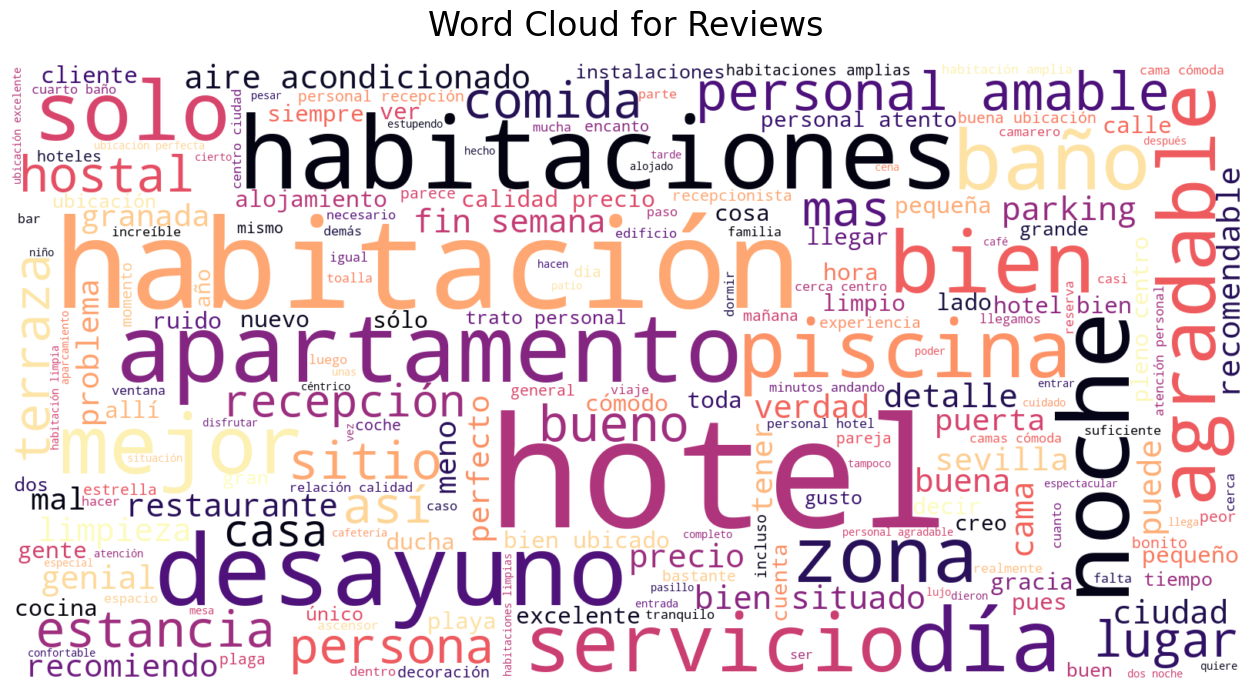

In [327]:
generate_wordcloud(reviews_df, "review_text", 'wordcloud_post_manual', random_seed)

---
## 4. Latent Dirichlet Allocation

### 4.1. Tokenize words

In [328]:
# Download the resources for NLTK spanish tokenizer

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('tagsets')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Carlos\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Carlos\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package tagsets to
[nltk_data]     C:\Users\Carlos\AppData\Roaming\nltk_data...
[nltk_data]   Package tagsets is already up-to-date!


True

In [329]:
# Tokenize the reviews if they are not already tokenized
tokens_df = reviews_df.copy()

tokens_df["review_text"] = tokens_df["review_text"].apply(
    lambda x: word_tokenize(x, language="spanish") if isinstance(x, str) else x
)

### 4.2. Corpus & Dictionaries

In [330]:
# Create Dictionary
id2word = corpora.Dictionary(tokens_df["review_text"])

# Create Corpus
texts = tokens_df["review_text"]

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1)]


---
## 5. Latent Dirichlet Allocation Training

### 5.1. Output functions

#### 5.1.1. Topic Wordclouds

In [331]:
def create_topic_wordclouds(lda_model, name, num_topics):
    for topic_num in range(num_topics):
        # Get the words associated with the topic
        topic_words = lda_model.show_topic(topic_num, topn=30)
        # Create a dictionary of topic words and their probabilities
        topic_word_dict = {word: prob for word, prob in topic_words}
        
        # Generate a word cloud for the topic
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(topic_word_dict)
        
        # Display the word cloud for the topic
        plt.figure(figsize=(8, 4))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(f'Topic {topic_num + 1} Word Cloud')
        plt.axis("off")
        plt.savefig(f'../images/topic_{name}_{topic_num + 1}_wordcloud.png')


In [332]:
import matplotlib.colors as mcolors


def create_multiple_topic_wordclouds(
    lda_model, num_topics, width=2500, height=1800, max_words=20
):
    cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    cloud = WordCloud(
        background_color="white",
        width=width,
        height=height,
        max_words=max_words,
        colormap="tab10",
    )

    topics = lda_model.show_topics(formatted=False)

    # Calculate the number of rows for subplots
    num_rows = (num_topics + 1) // 2

    # Create subplots
    fig, axes = plt.subplots(2, 5, figsize=(15, 15), sharex=True, sharey=True)

    for i, ax in enumerate(axes.flatten()):
        if i < num_topics:
            topic_words = dict(topics[i][1])
            cloud.generate_from_frequencies(topic_words, max_font_size=300)
            ax.imshow(cloud)
            ax.set_title("Topic " + str(i), fontdict=dict(size=16))
            ax.axis("off")
        else:
            # Remove extra subplots if there are more than 'num_topics'
            fig.delaxes(ax)

    plt.tight_layout()
    plt.show()

#### 5.1.2. Intertopic Distance Map

In [333]:
def intertopic_distance(lda_model, name, corpus):
  pyLDAvis.enable_notebook()
  vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
  pyLDAvis.save_html(vis, f'../images/{name}.html')
  return vis

### 5.2. LDA Model 1. 10 Topics

Better to use gensim library rather than scykitlearn

In [334]:
# number of topics
num_topics = 10

# Build LDA model
lda_model1 = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics,
                                       random_state=10,)
# Print the Keyword in the 10 topics
print(lda_model1.print_topics())
doc_lda = lda_model1[corpus]

[(0, '0.021*"hotel" + 0.016*"habitación" + 0.011*"personal" + 0.009*"habitaciones" + 0.009*"bien" + 0.007*"desayuno" + 0.006*"centro" + 0.005*"amable" + 0.005*"cama" + 0.005*"piscina"'), (1, '0.012*"hotel" + 0.010*"bien" + 0.009*"habitación" + 0.008*"buena" + 0.006*"centro" + 0.006*"personal" + 0.006*"zona" + 0.006*"baño" + 0.006*"desayuno" + 0.005*"lugar"'), (2, '0.023*"hotel" + 0.012*"habitación" + 0.012*"bien" + 0.010*"habitaciones" + 0.007*"recepción" + 0.007*"personal" + 0.006*"servicio" + 0.005*"baño" + 0.005*"ubicación" + 0.005*"centro"'), (3, '0.023*"bien" + 0.014*"hotel" + 0.009*"habitación" + 0.009*"habitaciones" + 0.008*"ubicación" + 0.008*"centro" + 0.007*"personal" + 0.007*"buena" + 0.006*"excelente" + 0.006*"limpio"'), (4, '0.020*"hotel" + 0.012*"habitación" + 0.008*"lugar" + 0.008*"bien" + 0.007*"habitaciones" + 0.006*"personal" + 0.006*"desayuno" + 0.005*"ciudad" + 0.004*"ubicación" + 0.004*"comida"'), (5, '0.029*"hotel" + 0.018*"habitación" + 0.011*"desayuno" + 0.009*"

#### 5.2.1. Output

c:\Users\Carlos\Desktop\Universidad\Inteligencia Artificial en las Organizaciones\Labs\Lab2\.venv\Lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


c:\Users\Carlos\Desktop\Universidad\Inteligencia Artificial en las Organizaciones\Labs\Lab2\.venv\Lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)
c:\Users\Carlos\Desktop\Universidad\Inteligencia Artificial en las Organizaciones\Labs\Lab2\.venv\Lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)
c:\Users\Carlos\Desktop\Universidad\Inteligencia Artificial en las Organizaciones\Labs\Lab2\.venv\Lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap fun

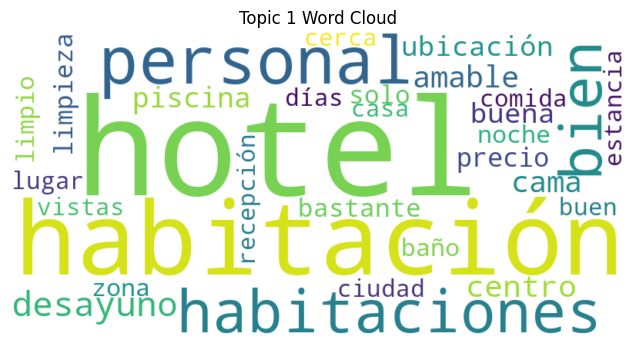

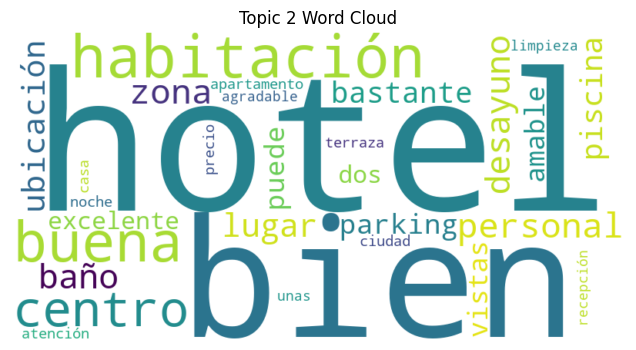

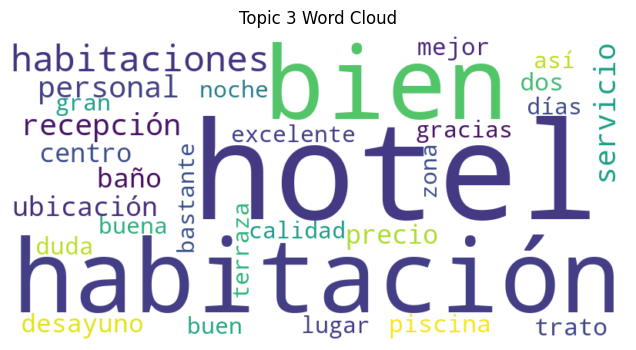

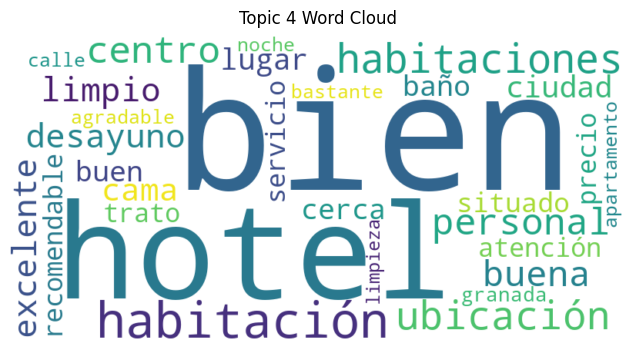

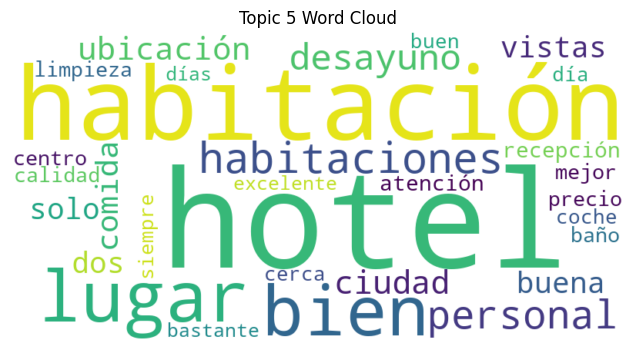

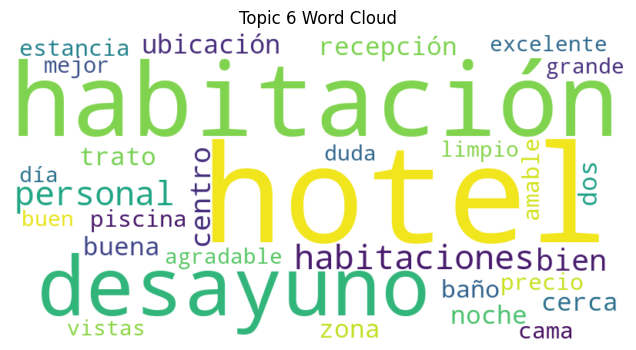

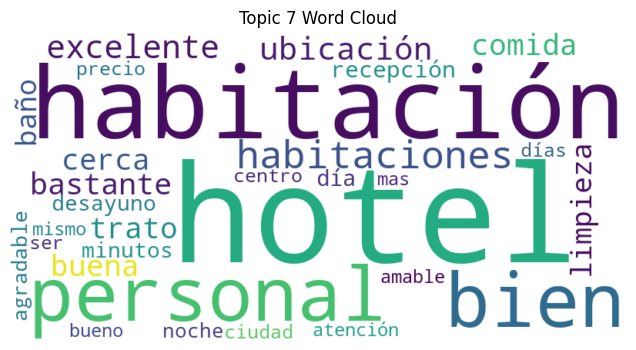

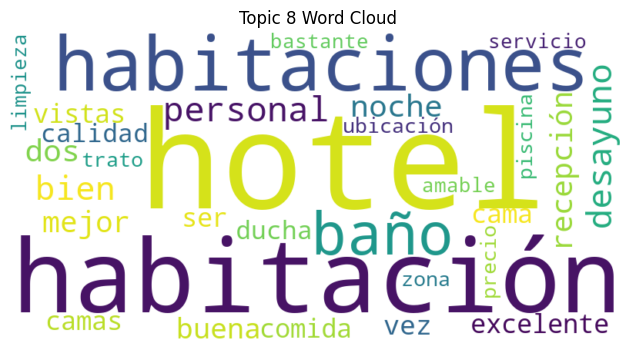

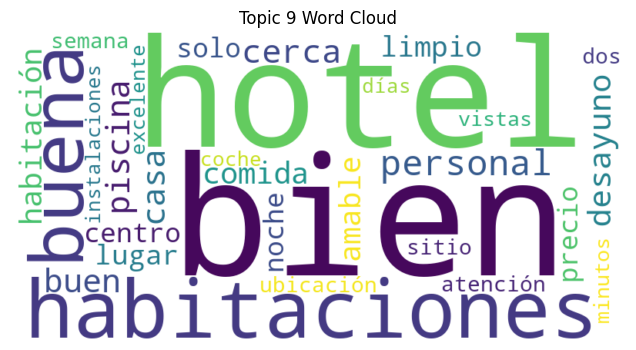

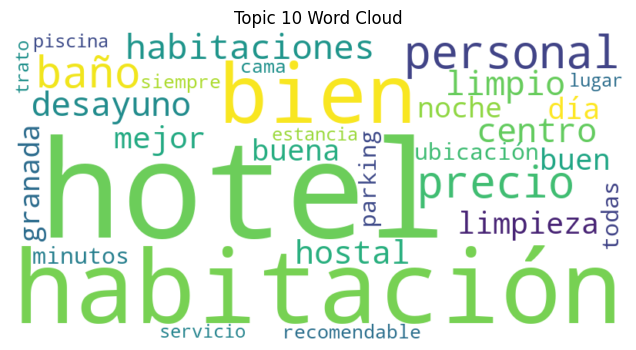

In [335]:
create_topic_wordclouds(lda_model1, 'lda_model1', num_topics)

In [336]:
# create_multiple_topic_wordclouds(lda_model1, num_topics)

In [337]:
intertopic_distance(lda_model1, 'lda_model1', corpus)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.009055 -0.008526       1        1  19.899679
7      0.021266  0.003799       2        1  11.905182
3     -0.005554 -0.018402       3        1  11.662660
0      0.002691 -0.001724       4        1  10.688467
2      0.002573 -0.009187       5        1   9.839549
9      0.015155 -0.008338       6        1   8.842335
6      0.013050 -0.010792       7        1   7.669244
1     -0.018205  0.006803       8        1   7.381921
8     -0.048179  0.001141       9        1   7.062280
4      0.008148  0.045226      10        1   5.048683, topic_info=          Term          Freq         Total Category  logprob  loglift
95        bien   6918.000000   6918.000000  Default  30.0000  30.0000
8        hotel  13678.000000  13678.000000  Default  29.0000  29.0000
75       lugar   2338.000000   2338.000000  Default  28.0000  28.0000
202     comida   1838.000000   1838.000000  Default  27.0000  27.0000
10    personal   5375.000000   5375.000000  Default  26.0000  26.0000
..         ...           ...           ...      ...      ...      ...
2       centro    111.463306   3367.938816  Topic10  -5.7057  -0.4223
17         vez     81.524339   1342.633111  Topic10  -6.0185   0.1846
156       días     83.950463   1548.103818  Topic10  -5.9892   0.0715
55   excelente     85.861114   2275.001301  Topic10  -5.9667  -0.2910
84    bastante     83.256865   2164.619013  Topic10  -5.9975  -0.2720

[913 rows x 6 columns], token_table=       Topic      Freq   Term
term                         
19510      3  0.062544   1340
19510      6  0.813067   1340
19510     10  0.062544   1340
5525       1  0.033387   1430
5525       2  0.133548   1430
...      ...       ...    ...
82         6  0.144145  único
82         7  0.086984  único
82         8  0.067102  único
82         9  0.062132  único
82        10  0.059646  único

[2539 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 8, 4, 1, 3, 10, 7, 2, 9, 5])

### 5.3. LDA Model 2. 10 Topics with Parameter Tunning

In [338]:
# number of topics
num_topics = 10

# Define LDA model parameters
lda_params = {
    'corpus': corpus,
    'id2word': id2word,
    'num_topics': num_topics,
    'random_state': 10,  # Reproducibility seed
    'passes': 30,  # Increase the number of passes for better convergence
    'eta': 'auto',  # Automatically set eta
}

# Build LDA model
lda_model2 = gensim.models.LdaMulticore(**lda_params)

# Print the Keyword in the 10 topics
print(lda_model2.print_topics())
doc_lda = lda_model2[corpus]

[(0, '0.016*"hotel" + 0.012*"habitación" + 0.009*"habitaciones" + 0.009*"piscina" + 0.007*"bien" + 0.006*"bastante" + 0.006*"mas" + 0.006*"personal" + 0.005*"cama" + 0.005*"habia"'), (1, '0.010*"piscina" + 0.008*"estancia" + 0.008*"casa" + 0.008*"lugar" + 0.007*"zona" + 0.006*"terraza" + 0.005*"niños" + 0.005*"vistas" + 0.005*"bien" + 0.005*"ambiente"'), (2, '0.026*"hotel" + 0.012*"habitaciones" + 0.010*"servicio" + 0.008*"bien" + 0.007*"recepción" + 0.006*"piscina" + 0.006*"gracias" + 0.005*"personal" + 0.005*"mejor" + 0.004*"desayuno"'), (3, '0.025*"bien" + 0.016*"hotel" + 0.014*"personal" + 0.013*"centro" + 0.013*"habitaciones" + 0.012*"ubicación" + 0.012*"buena" + 0.011*"limpio" + 0.010*"excelente" + 0.009*"cerca"'), (4, '0.015*"lugar" + 0.009*"clive" + 0.007*"comida" + 0.007*"anfitriones" + 0.006*"bien" + 0.006*"noches" + 0.006*"gran" + 0.006*"día" + 0.006*"casa" + 0.006*"maki"'), (5, '0.040*"hotel" + 0.022*"habitación" + 0.014*"desayuno" + 0.014*"personal" + 0.012*"bien" + 0.011*

#### 5.3.1. Output

c:\Users\Carlos\Desktop\Universidad\Inteligencia Artificial en las Organizaciones\Labs\Lab2\.venv\Lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


c:\Users\Carlos\Desktop\Universidad\Inteligencia Artificial en las Organizaciones\Labs\Lab2\.venv\Lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)
c:\Users\Carlos\Desktop\Universidad\Inteligencia Artificial en las Organizaciones\Labs\Lab2\.venv\Lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)
c:\Users\Carlos\Desktop\Universidad\Inteligencia Artificial en las Organizaciones\Labs\Lab2\.venv\Lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap fun

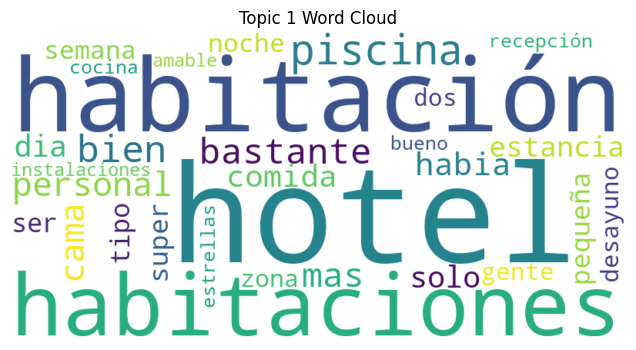

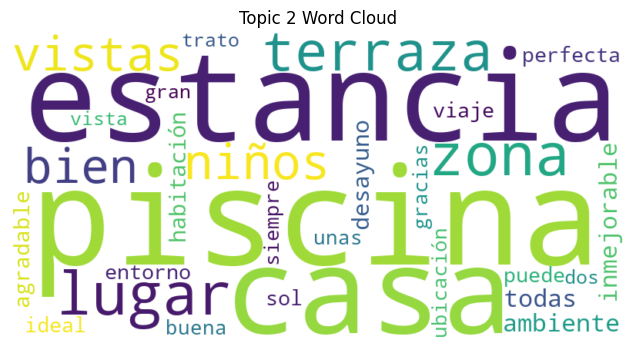

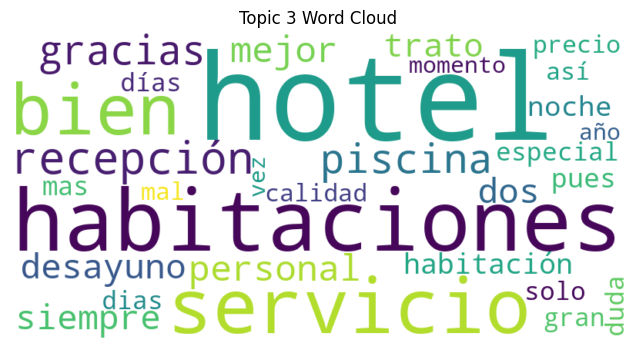

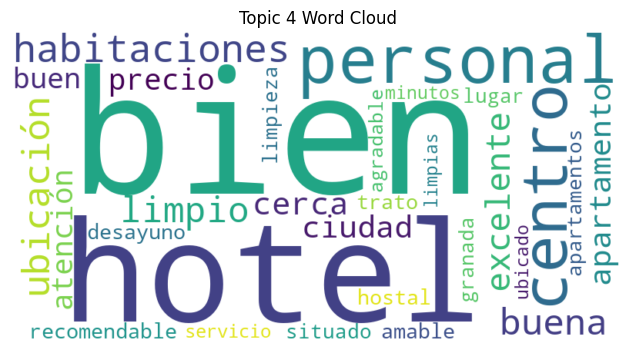

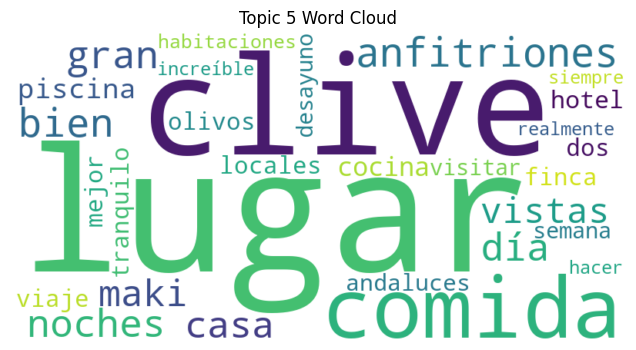

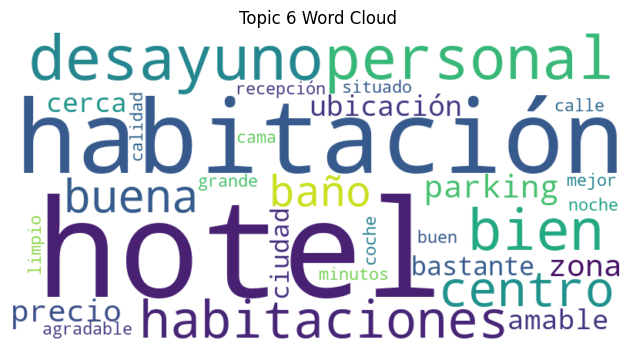

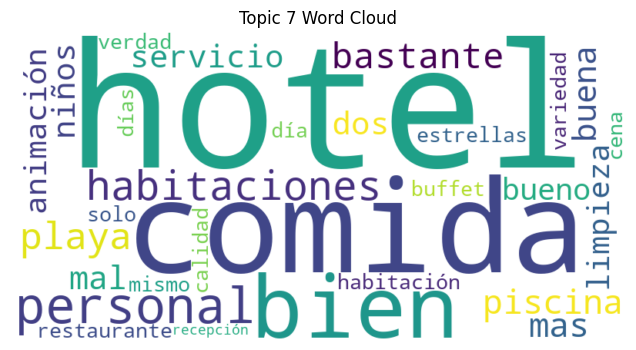

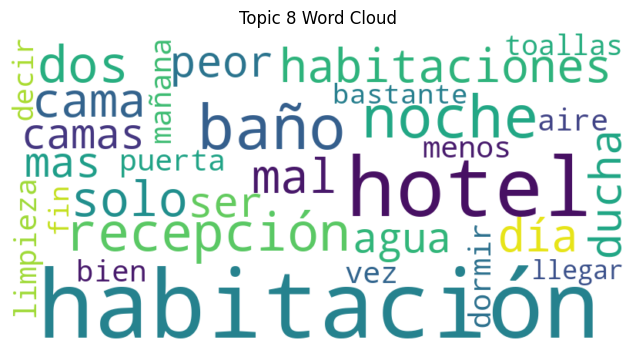

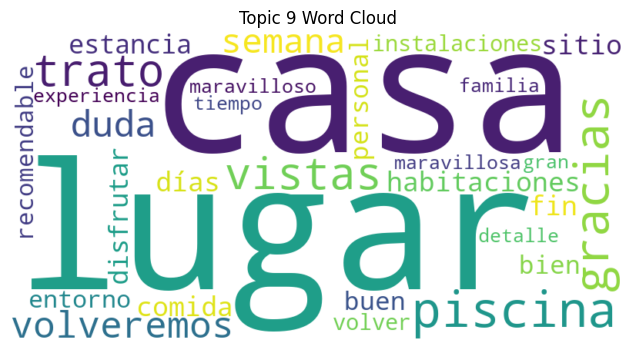

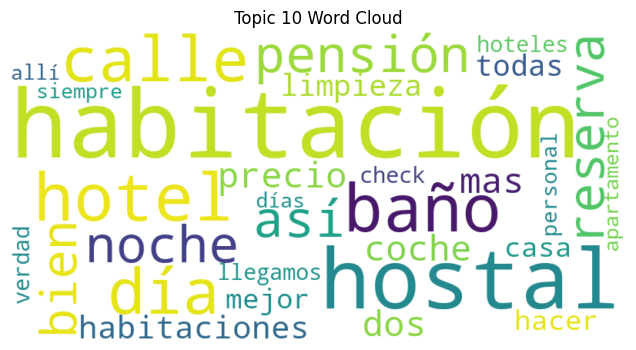

In [339]:
create_topic_wordclouds(lda_model2, 'lda_model2', num_topics)

In [340]:
# create_multiple_topic_wordclouds(lda_model2, num_topics)

In [341]:
intertopic_distance(lda_model2, 'lda_model2', corpus)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.036245 -0.138605       1        1  28.519976
7      0.162539  0.081908       2        1  17.824145
3     -0.011367 -0.181313       3        1  17.126557
8     -0.177147 -0.019753       4        1   8.119922
6      0.111151  0.010134       5        1   5.941396
2      0.042720 -0.021800       6        1   5.271568
9      0.101438  0.062655       7        1   4.884086
0      0.083759  0.065044       8        1   4.246338
4     -0.187359  0.113907       9        1   4.060053
1     -0.161979  0.027825      10        1   4.005960, topic_info=           Term          Freq         Total Category  logprob  loglift
8         hotel  14420.000000  14420.000000  Default  30.0000  30.0000
75        lugar   2306.000000   2306.000000  Default  29.0000  29.0000
7    habitación   8411.000000   8411.000000  Default  28.0000  28.0000
388     piscina   2446.000000   2446.000000  Default  27.0000  27.0000
202      comida   1757.000000   1757.000000  Default  26.0000  26.0000
..          ...           ...           ...      ...      ...      ...
16    ubicación     80.070667   3212.179560  Topic10  -5.8052  -0.4744
21        buena     79.730021   3570.921060  Topic10  -5.8094  -0.5845
73         gran     73.754782   1213.830379  Topic10  -5.8873   0.4166
35        trato     73.314315   2326.777197  Topic10  -5.8933  -0.2401
252         dos     72.219278   2369.735168  Topic10  -5.9084  -0.2734

[917 rows x 6 columns], token_table=       Topic      Freq   Term
term                         
6162       7  0.943372   0700
19510      7  0.954259   1340
5525       2  0.114929   1430
5525       6  0.057465   1430
5525       7  0.775771   1430
...      ...       ...    ...
1895       2  0.103236  ático
1895       3  0.017206  ático
1895       8  0.585002  ático
7894       6  0.087372  éxito
7894       8  0.873724  éxito

[2782 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 8, 4, 9, 7, 3, 10, 1, 5, 2])

### 5.4. LDA Model 3. 4 Topics

In [342]:
# number of topics
num_topics = 4

# Build LDA model
lda_model3 = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics,
                                       random_state=10,)

# Print the Keyword in the 10 topics
print(lda_model3.print_topics())
doc_lda = lda_model3[corpus]

[(0, '0.024*"hotel" + 0.016*"habitación" + 0.011*"personal" + 0.009*"habitaciones" + 0.008*"desayuno" + 0.008*"bien" + 0.005*"centro" + 0.005*"amable" + 0.005*"buena" + 0.004*"cama"'), (1, '0.015*"hotel" + 0.010*"habitación" + 0.008*"bien" + 0.007*"buena" + 0.006*"desayuno" + 0.006*"personal" + 0.006*"baño" + 0.005*"centro" + 0.005*"zona" + 0.005*"lugar"'), (2, '0.024*"hotel" + 0.013*"habitación" + 0.010*"habitaciones" + 0.009*"bien" + 0.007*"personal" + 0.006*"recepción" + 0.005*"baño" + 0.005*"desayuno" + 0.005*"servicio" + 0.005*"ubicación"'), (3, '0.017*"bien" + 0.016*"hotel" + 0.010*"habitación" + 0.009*"habitaciones" + 0.007*"personal" + 0.007*"ubicación" + 0.006*"buena" + 0.006*"centro" + 0.006*"desayuno" + 0.005*"excelente"')]


#### 5.4.1. Output

c:\Users\Carlos\Desktop\Universidad\Inteligencia Artificial en las Organizaciones\Labs\Lab2\.venv\Lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


c:\Users\Carlos\Desktop\Universidad\Inteligencia Artificial en las Organizaciones\Labs\Lab2\.venv\Lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)
c:\Users\Carlos\Desktop\Universidad\Inteligencia Artificial en las Organizaciones\Labs\Lab2\.venv\Lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)
c:\Users\Carlos\Desktop\Universidad\Inteligencia Artificial en las Organizaciones\Labs\Lab2\.venv\Lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap fun

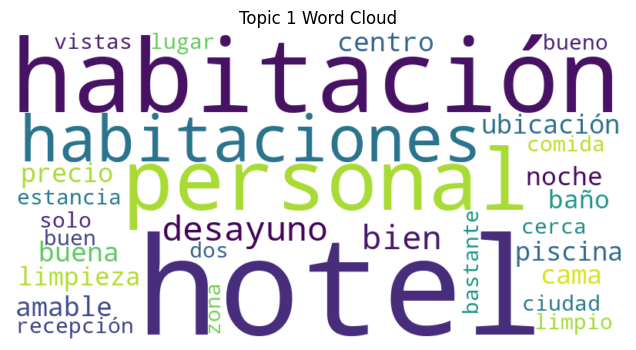

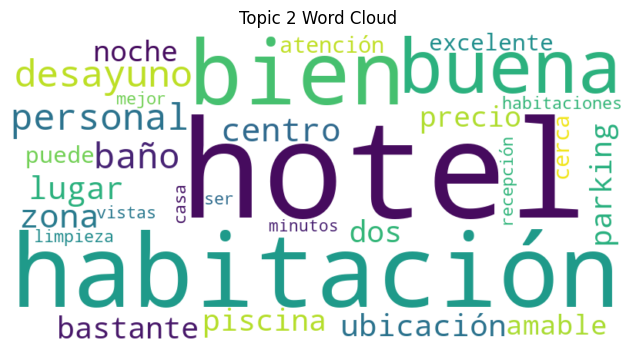

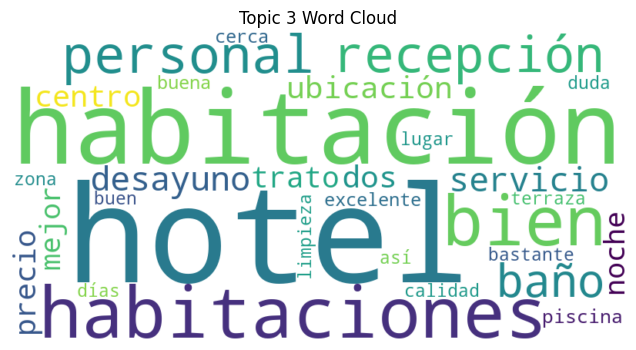

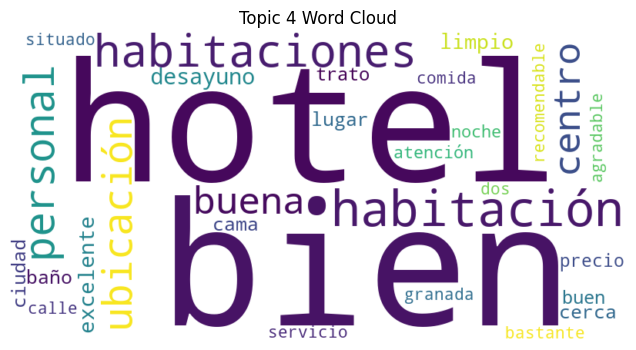

In [343]:
create_topic_wordclouds(lda_model3, 'lda_model3', num_topics)

In [344]:
# create_multiple_topic_wordclouds(lda_model3, num_topics)

In [345]:
intertopic_distance(lda_model3, 'lda_model3', corpus)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.000310  0.008006       1        1  29.853378
2     -0.003376  0.011791       2        1  25.818309
3     -0.013990 -0.012386       3        1  24.867957
1      0.017676 -0.007411       4        1  19.460356, topic_info=             Term         Freq        Total Category  logprob  loglift
95           bien  6947.000000  6947.000000  Default  30.0000  30.0000
21          buena  3419.000000  3419.000000  Default  29.0000  29.0000
55      excelente  2259.000000  2259.000000  Default  28.0000  28.0000
140     recepción  2602.000000  2602.000000  Default  27.0000  27.0000
111          zona  2182.000000  2182.000000  Default  26.0000  26.0000
..            ...          ...          ...      ...      ...      ...
165      limpieza   410.544656  2124.933471   Topic4  -5.7512  -0.0072
3           cerca   428.450607  2406.428754   Topic4  -5.7085  -0.0889
140     recepción   417.132362  2602.177085   Topic4  -5.7353  -0.1939
26       estancia   366.678716  1802.430296   Topic4  -5.8642   0.0444
74   habitaciones   422.623821  5287.056315   Topic4  -5.7222  -0.8897

[357 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
19506      1  0.789944  acabaron
19506      4  0.131657  acabaron
433        1  0.235138  acogedor
433        2  0.136532  acogedor
433        3  0.405045  acogedor
...      ...       ...       ...
6431       4  0.659208   yolanda
111        1  0.296457      zona
111        2  0.233225      zona
111        3  0.177324      zona
111        4  0.293249      zona

[702 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 4, 2])

### 5.5. LDA Model 4. 4 Topics with Parameter Tunning

In [357]:
# number of topics
num_topics = 4

# Define LDA model parameters
lda_params = {
    'corpus': corpus,
    'id2word': id2word,
    'num_topics': num_topics,
    'random_state': 10,  # Reproducibility seed
    'passes': 40,  # Increase the number of passes for better convergence
    'eta': 'auto',  # Automatically set eta
}

# Build LDA model
lda_model4 = gensim.models.LdaMulticore(**lda_params)

# Print the Keyword in the 10 topics
print(lda_model4.print_topics())
doc_lda = lda_model4[corpus]

[(0, '0.023*"habitación" + 0.015*"hotel" + 0.009*"baño" + 0.007*"habitaciones" + 0.006*"noche" + 0.006*"cama" + 0.005*"bien" + 0.005*"recepción" + 0.005*"dos" + 0.005*"solo"'), (1, '0.013*"lugar" + 0.010*"casa" + 0.009*"piscina" + 0.007*"vistas" + 0.006*"estancia" + 0.006*"gracias" + 0.005*"gran" + 0.005*"comida" + 0.004*"habitaciones" + 0.004*"duda"'), (2, '0.024*"hotel" + 0.007*"comida" + 0.006*"piscina" + 0.006*"bien" + 0.005*"servicio" + 0.005*"habitación" + 0.005*"habitaciones" + 0.005*"dos" + 0.005*"personal" + 0.004*"día"'), (3, '0.032*"hotel" + 0.018*"bien" + 0.015*"personal" + 0.013*"habitación" + 0.013*"habitaciones" + 0.011*"centro" + 0.011*"desayuno" + 0.010*"buena" + 0.009*"ubicación" + 0.008*"cerca"')]


#### 5.2.1. Output

c:\Users\Carlos\Desktop\Universidad\Inteligencia Artificial en las Organizaciones\Labs\Lab2\.venv\Lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


c:\Users\Carlos\Desktop\Universidad\Inteligencia Artificial en las Organizaciones\Labs\Lab2\.venv\Lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)
c:\Users\Carlos\Desktop\Universidad\Inteligencia Artificial en las Organizaciones\Labs\Lab2\.venv\Lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)
c:\Users\Carlos\Desktop\Universidad\Inteligencia Artificial en las Organizaciones\Labs\Lab2\.venv\Lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap fun

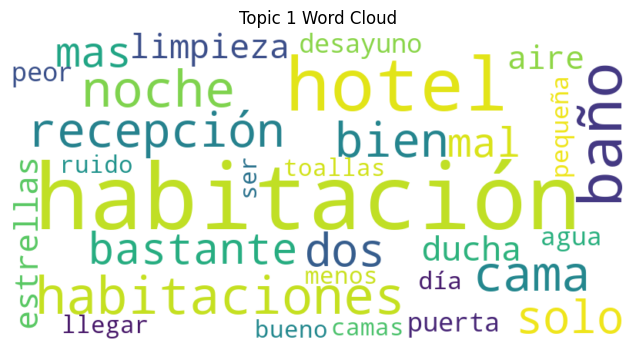

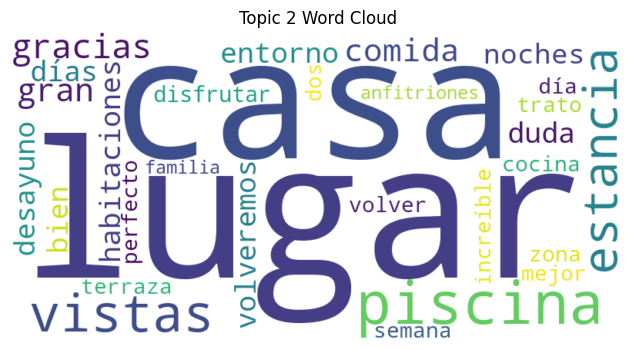

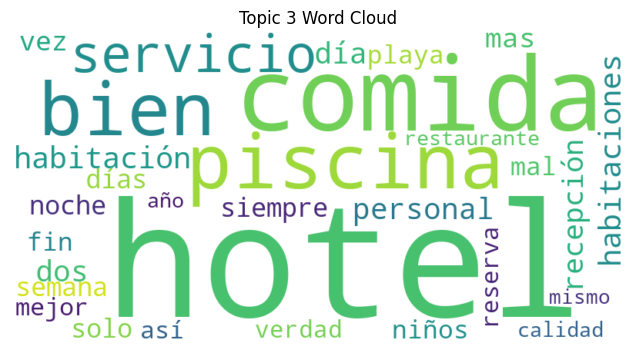

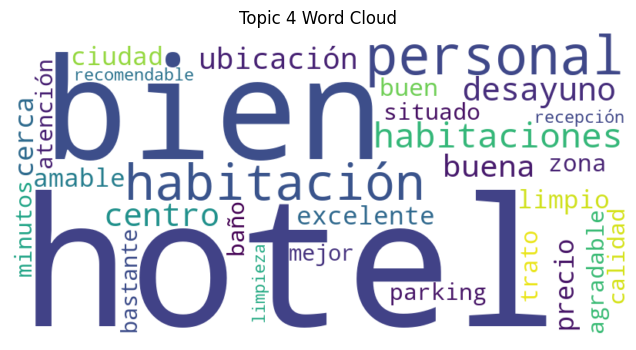

In [358]:
create_topic_wordclouds(lda_model4, 'lda_model4', num_topics)

In [348]:
# create_multiple_topic_wordclouds(lda_model4, num_topics)

In [359]:
intertopic_distance(lda_model4, 'lda_model4', corpus)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.032254  0.158078       1        1  45.230581
0     -0.150743 -0.002952       2        1  24.328105
1      0.201241 -0.064723       3        1  15.225235
2     -0.082753 -0.090403       4        1  15.216079, topic_info=           Term          Freq         Total Category  logprob  loglift
8         hotel  14489.000000  14489.000000  Default  30.0000  30.0000
75        lugar   2278.000000   2278.000000  Default  29.0000  29.0000
2        centro   3415.000000   3415.000000  Default  28.0000  28.0000
773        casa   1454.000000   1454.000000  Default  27.0000  27.0000
7    habitación   8315.000000   8315.000000  Default  26.0000  26.0000
..          ...           ...           ...      ...      ...      ...
10     personal    456.227458   5576.397442   Topic4  -5.3997  -0.6205
7    habitación    507.388767   8315.967411   Topic4  -5.2934  -0.9138
43        mejor    312.168919   2191.693990   Topic4  -5.7791  -0.0661
517       mismo    265.264547   1018.637328   Topic4  -5.9419   0.5373
375     calidad    283.425966   1939.565837   Topic4  -5.8757  -0.0405

[367 rows x 6 columns], token_table=       Topic      Freq           Term
term                                 
5525       4  0.969451           1430
984        1  0.414122  acondicionado
984        2  0.500049  acondicionado
984        3  0.013128  acondicionado
984        4  0.072800  acondicionado
...      ...       ...            ...
19654      3  0.991389         zanjar
111        1  0.754995           zona
111        2  0.059358           zona
111        3  0.143483           zona
111        4  0.042703           zona

[745 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 2, 3])

---
## 6. Evaluation

**Coherence Score**: Coherence score quantifies the interpretability and consistency of topics in a topic model; higher coherence scores indicate more meaningful and coherent topics within the model.

**Perplexity**: Perplexity is a measure of how well a probabilistic model, such as a language model or a topic model, predicts a given dataset; lower perplexity values indicate that the model better captures the data's underlying patterns and is more confident in its predictions.

In [360]:
from gensim.models import CoherenceModel

In [361]:
# Evaluate Model 1
coherence_model1 = CoherenceModel(model=lda_model1, texts=texts, dictionary=id2word, coherence='c_v')
coherence1 = coherence_model1.get_coherence()
perplexity1 = lda_model1.log_perplexity(corpus)

In [362]:
# Evaluate Model 2
coherence_model2 = CoherenceModel(model=lda_model2, texts=texts, dictionary=id2word, coherence='c_v')
coherence2 = coherence_model2.get_coherence()
perplexity2 = lda_model2.log_perplexity(corpus)

In [363]:
# Evaluate Model 3
coherence_model3 = CoherenceModel(model=lda_model3, texts=texts, dictionary=id2word, coherence='c_v')
coherence3 = coherence_model3.get_coherence()
perplexity3 = lda_model3.log_perplexity(corpus)

In [364]:
# Evaluate Model 4
coherence_model4 = CoherenceModel(model=lda_model4, texts=texts, dictionary=id2word, coherence='c_v')
coherence4 = coherence_model4.get_coherence()
perplexity4 = lda_model4.log_perplexity(corpus)

### 6.1. Coherence scores

In [365]:
# Coherence scores
print(f"Coherence Score for Model 1: {coherence1}")
print(f"Coherence Score for Model 2: {coherence2}")
print(f"Coherence Score for Model 3: {coherence3}")
print(f"Coherence Score for Model 4: {coherence4}")

Coherence Score for Model 1: 0.2966272709153037
Coherence Score for Model 2: 0.37938306617120143
Coherence Score for Model 3: 0.3118132509877044
Coherence Score for Model 4: 0.3862955870239959


### 6.2. Perplexity scores

In [366]:
# Perplexity scores
print(f"Perplexity for Model 1: {perplexity1}")
print(f"Perplexity for Model 2: {perplexity2}")
print(f"Perplexity for Model 3: {perplexity3}")
print(f"Perplexity for Model 4: {perplexity4}")

Perplexity for Model 1: -8.160528262942673
Perplexity for Model 2: -7.897930874886522
Perplexity for Model 3: -8.023916826810304
Perplexity for Model 4: -7.799770986416284
